## IMPORTING 

#### Getting the necessary libraries and data

In [218]:
# General libraries
import pandas as pd
import numpy as np
from scipy import stats 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BASE_COLORS
%matplotlib inline


# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks,RandomUnderSampler,NearMiss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, confusion_matrix,plot_confusion_matrix,cohen_kappa_score,accuracy_score,recall_score,precision_score,f1_score,classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [219]:
df = pd.read_excel("data/creditcardmarketing_clean.xlsx")

# Data exploration
**Taking a quick look at dataset**

In [220]:
df.head(5)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [221]:
df.describe()

,Customer Number,# Bank Accounts Open,# Credit Cards Held,# Homes Owned,Household Size,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,9000.500000,1.255778,1.903500,1.203444,3.499056,940.515562,910.450656,999.392190,1042.033600,810.185803
std,5196.296758,0.472501,0.797009,0.427341,1.114182,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,4500.750000,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,9000.500000,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,13500.250000,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,18000.000000,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


In [222]:
df["Customer Number"].nunique()==df["Customer Number"].count()

True

#### Dropping customer number, clearly we're not gonna use it.

In [223]:
df.drop('Customer Number', axis=1, inplace=True)

**To make our life easier we'll rename columns to lowercase and without spaces or weird symbols**

In [224]:
df.columns= df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('#_','')

#### Checking for null values

In [225]:
#Spotting the nulls
df.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
bank_accounts_open       0
overdraft_protection     0
credit_rating            0
credit_cards_held        0
homes_owned              0
household_size           0
own_your_home            0
average_balance         24
q1_balance              24
q2_balance              24
q3_balance              24
q4_balance              24
dtype: int64

#### NULLS: 24 out of a total of 18000 rows is not significant so I am dropping them, replacing it with the median or mean could also be a good approach


In [226]:
# Dropping the rows with null values
df.dropna( inplace= True)

Remember to reset index every time you drop rows so you won't get additional nulls when concatenating later!

In [227]:
df=df.reset_index(drop=True)

# FEATURE SELECTION

#### First we'll split our numerical and categorical types into different dataframes

In [228]:
df_numeric = df._get_numeric_data() # Selecting Numerical Data
df_categorical = df.select_dtypes("object")# Selecting Categorical Data

In [229]:
df_numeric.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [230]:
df_categorical.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'overdraft_protection', 'credit_rating', 'own_your_home'],
      dtype='object')

## Numerical Data : Exploration

#### Now let's explore the dataframes separately, to check distribution, correlations and outliers.

In [231]:
df_numeric.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0


#### Plotting the distribution with sns.distplot.

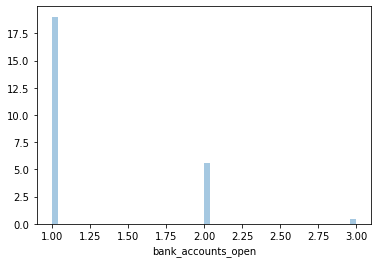

Skewness for bank_accounts_open :  1.5774006502627758


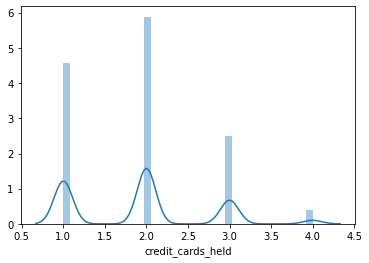

Skewness for credit_cards_held :  0.5140513822808801


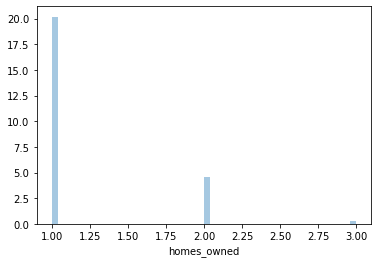

Skewness for homes_owned :  1.860769745992946


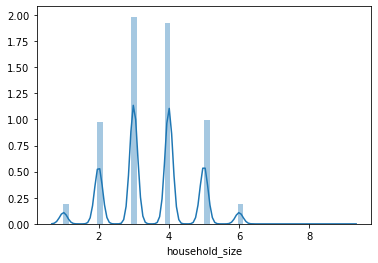

Skewness for household_size :  0.016946629549552998


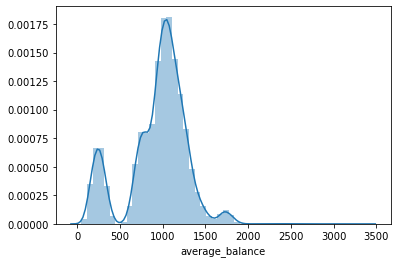

Skewness for average_balance :  -0.5723407970872233


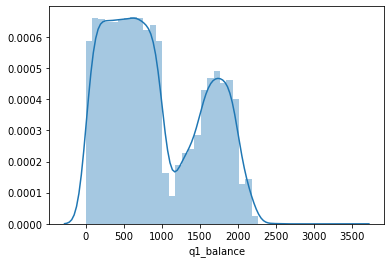

Skewness for q1_balance :  0.4109111821855019


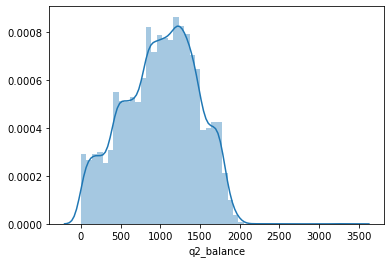

Skewness for q2_balance :  -0.18299270673139534


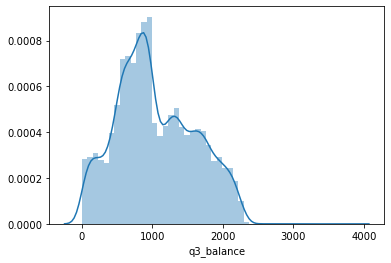

Skewness for q3_balance :  0.28962875846919944


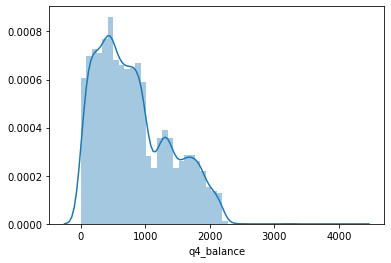

Skewness for q4_balance :  0.6411829058277463


In [232]:
# Displaying numerical columns distribution
for col in df_numeric.columns: 
    sns.distplot(df_numeric[col])
    Skewnes = df_numeric[col].skew()
    plt.show()
    print("Skewness for "+col+" : ", Skewnes ) #Skewness shows how much each feature varies from the normal distribution

#### From this distribution plot we can see that only the balances are continuous variables, so let's add the discrete ones to the categorical df :

In [233]:
df_numeric.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [234]:
df_categorical[["bank_accounts_open","credit_cards_held","homes_owned","household_size"]] = df_numeric [["bank_accounts_open","credit_cards_held","homes_owned","household_size"]]

In [235]:
df_numeric = df_numeric[["average_balance","q1_balance","q2_balance","q3_balance","q4_balance"]]

In [236]:
df_categorical.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,bank_accounts_open,credit_cards_held,homes_owned,household_size
0,No,Air Miles,Letter,High,No,High,No,1,2,1,4
1,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,2,5
2,No,Air Miles,Postcard,High,No,Medium,Yes,2,2,1,2
3,No,Air Miles,Letter,Medium,No,High,No,2,1,1,4
4,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,1,6


In [237]:
df_numeric.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1160.75,1669.0,877.0,1095.0,1002.0
1,147.25,39.0,106.0,78.0,366.0
2,276.50,367.0,352.0,145.0,242.0
3,1219.00,1578.0,1760.0,1119.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0


## Numerical Data : Correlation

#### Our objective is to find the features with higher correlation between them to avoid noisy and redundant data.
#### Plotting sns.pairplot to visualize the different distributions and correlations

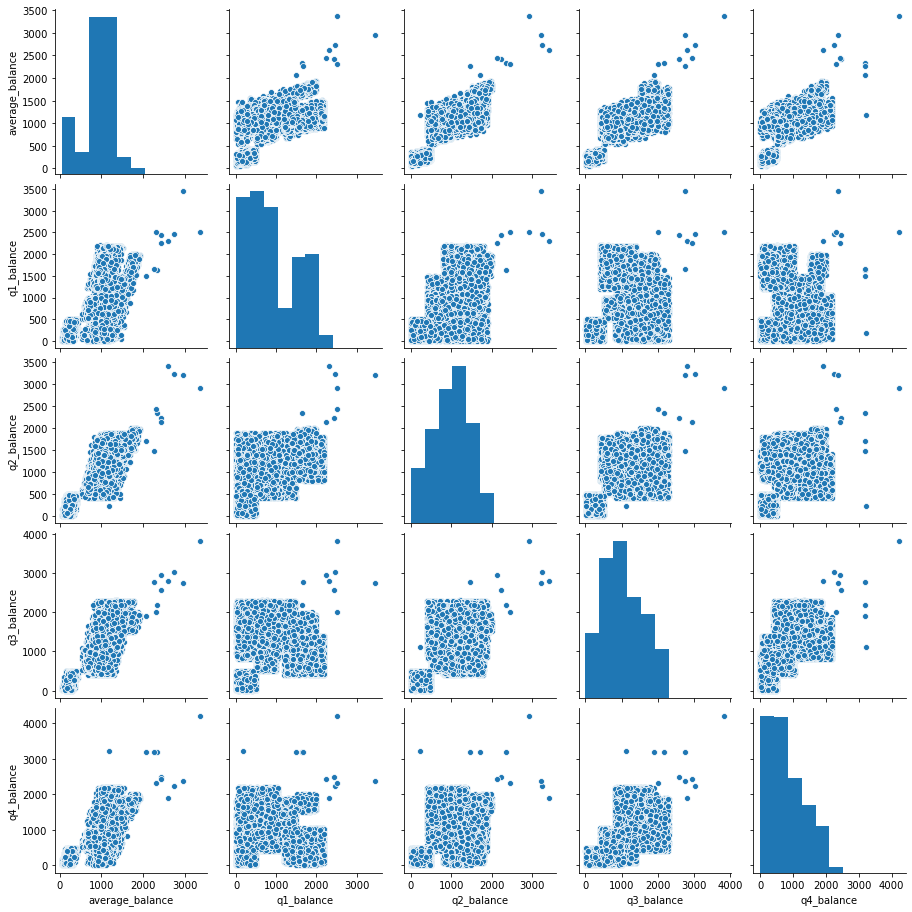

In [238]:
sns.pairplot(df_numeric)

#### Plotting correlation matrix to get detailed insights.

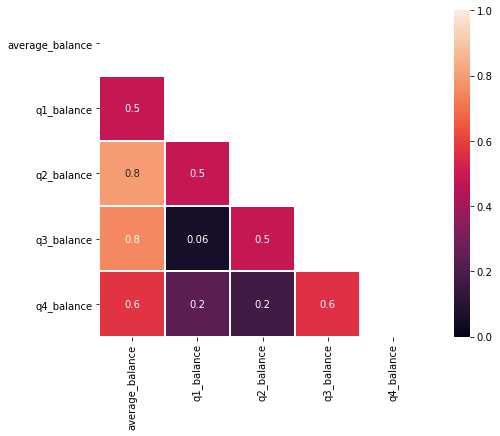

In [239]:
mask = np.zeros_like(df_numeric.corr().abs())
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(df_numeric.corr().abs(), mask=mask,
                square=True, annot=True, linewidths=1,
                vmax = 1, vmin = 0, fmt='.1g')

We see a high correlation between the **average_balance** and the **Q balances**, which makes sense since **average_balance** is the mean of them.

#### I will drop the average_balance to reduce noise since it is directly correlated with the rest of quarters.

In [240]:
df_numeric.drop(['average_balance'], axis = 1, inplace = True)

In [241]:
df_numeric.columns

Index(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'], dtype='object')

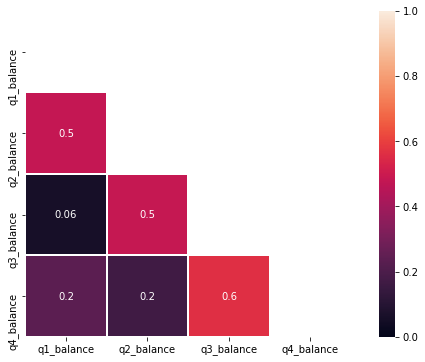

In [242]:
mask = np.zeros_like(df_numeric.corr().abs())
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(df_numeric.corr().abs(), mask=mask,
                square=True, annot=True, linewidths=1,
                vmax = 1, vmin = 0, fmt='.1g')

## Numerical Data : Spotting Outliers  

#### Plotting with sns.boxplot to visualize the outliers in the different columns on the people who accepted and rejected the offer

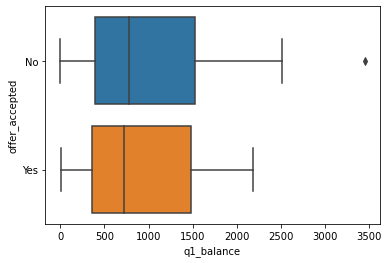

1st Quartile:  392.75  3rd Quartile:  1521.0


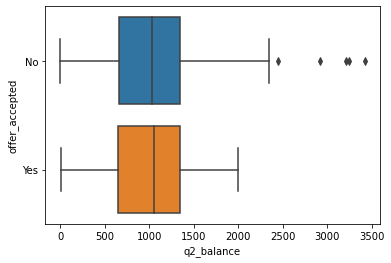

1st Quartile:  663.0  3rd Quartile:  1342.0


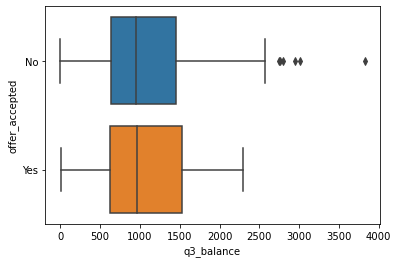

1st Quartile:  633.0  3rd Quartile:  1463.0


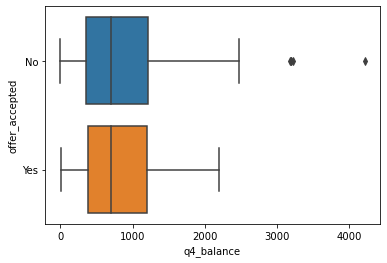

1st Quartile:  363.0  3rd Quartile:  1212.0


In [243]:
for col in df_numeric: # Visualizing Outliers
    sns.boxplot(x = df_numeric[col],y = "offer_accepted", data = df)
    
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    #Calculating Quartiles of that column
    
    plt.show()
    print("1st Quartile: ", Q1, " 3rd Quartile: ", Q3)

This clearly shows some outliers that mainly are on the side of the customers who reject the credit card offer, we'll deal with them later.

## Categorical Data : Exploration

#### Time to explore more deeply our categorical features.

In [244]:
df_categorical.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,bank_accounts_open,credit_cards_held,homes_owned,household_size
0,No,Air Miles,Letter,High,No,High,No,1,2,1,4
1,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,2,5
2,No,Air Miles,Postcard,High,No,Medium,Yes,2,2,1,2
3,No,Air Miles,Letter,Medium,No,High,No,2,1,1,4
4,No,Air Miles,Letter,Medium,No,Medium,Yes,1,2,1,6


#### Plotting sns.countplot to display to compare the distribution between the people who accepted and rejected the offer

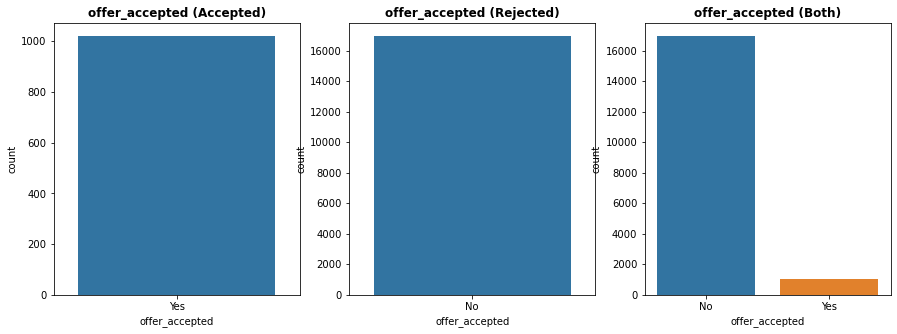

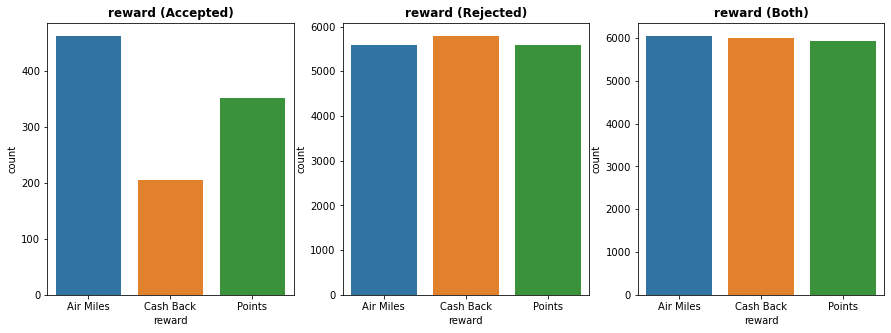

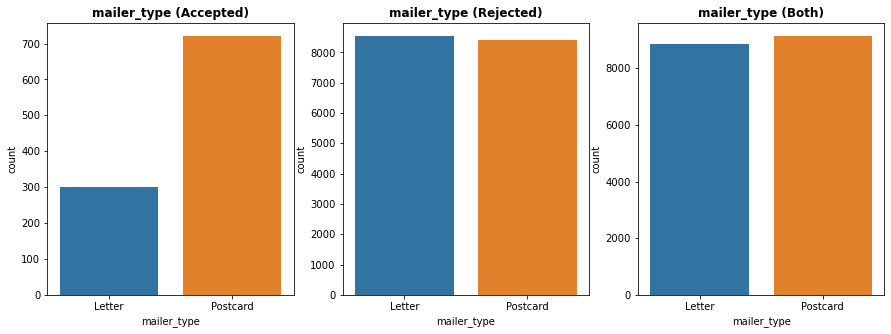

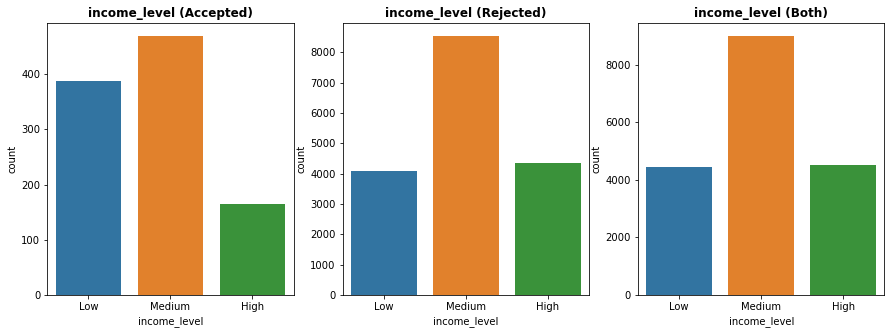

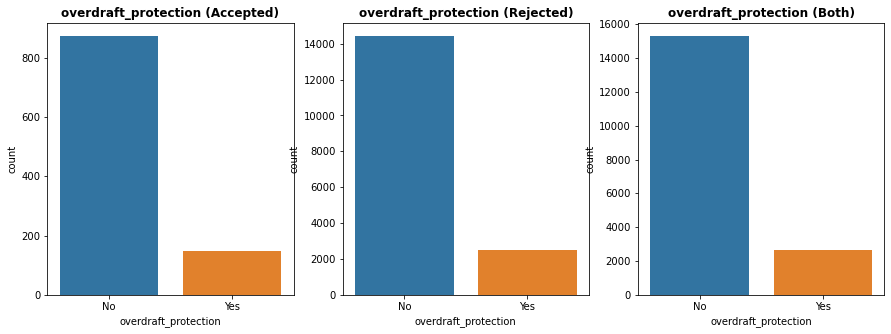

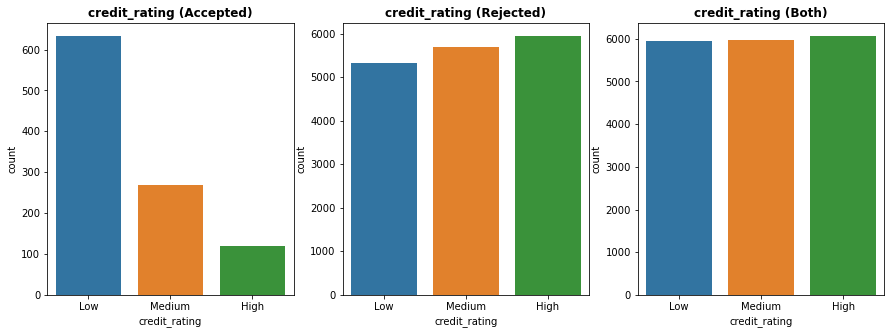

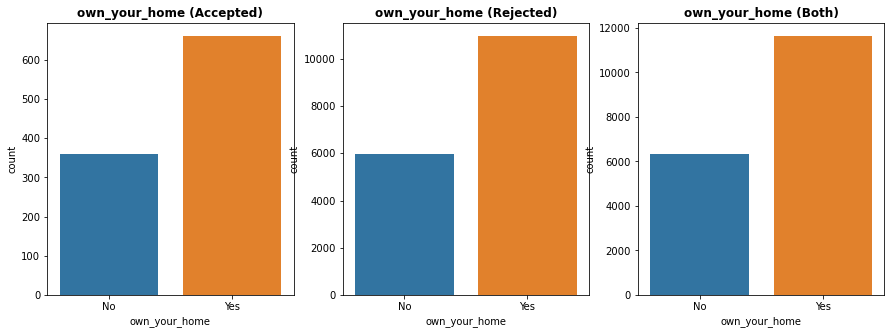

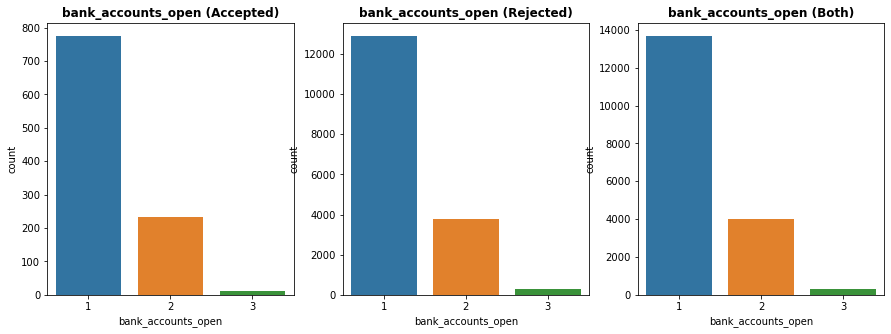

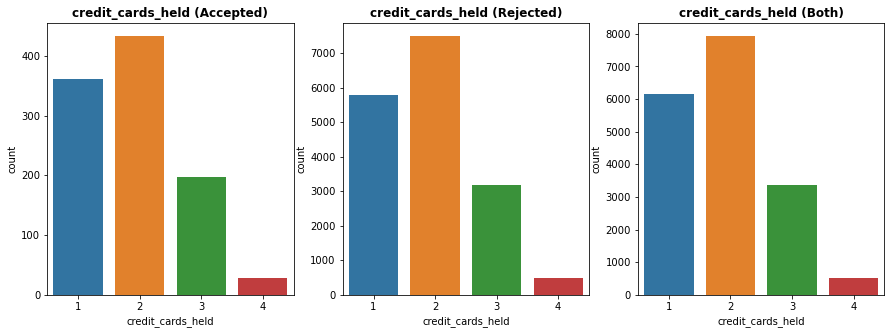

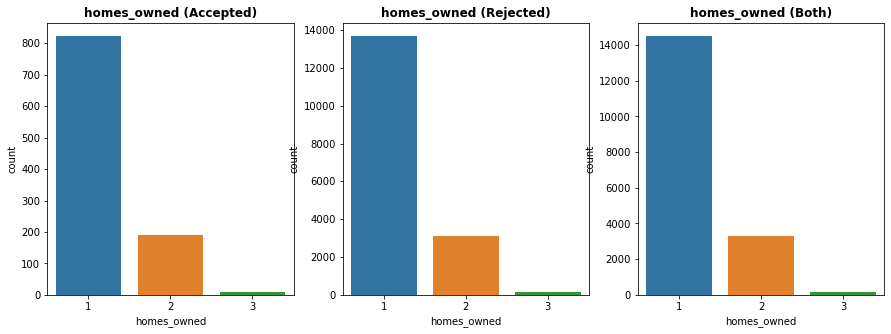

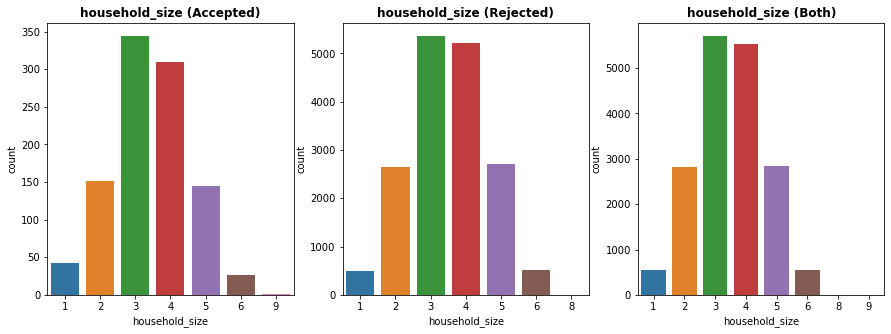

In [245]:
for col in df_categorical :
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].set_title(col+" (Accepted)", fontweight = 'bold')
    ax[1].set_title(col+" (Rejected)", fontweight = 'bold')
    ax[2].set_title(col+" (Both)", fontweight = 'bold')
    if col == "income_level" or col == "credit_rating":
        sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="Yes"],order=["Low","Medium","High"], ax = ax[0])
        sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="No"],order=["Low","Medium","High"], ax = ax[1])
        sns.countplot(x = col, data = df_categorical ,order=["Low","Medium","High"],ax = ax[2])
    else:
        sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="Yes"], ax = ax[0])
        sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="No"],ax = ax[1])
        sns.countplot(x = col, data = df_categorical ,ax = ax[2])
        
    plt.show()

In [246]:
df_categorical["household_size"].value_counts()

3    5705
4    5532
5    2851
2    2809
1     539
6     538
9       1
8       1
Name: household_size, dtype: int64

We can see that from 6 to 9 there are only 2 values and that's not enough for a model to get insights from them,  so let's just join them with the highest value.

In [247]:
df_categorical.household_size[df_categorical["household_size"] > 6] = 6

In [248]:
df_categorical["household_size"].value_counts()

3    5705
4    5532
5    2851
2    2809
6     540
1     539
Name: household_size, dtype: int64

In [249]:
#df_categorical.homes_owned[df_categorical["homes_owned"] == 3] = 2
#df_categorical.bank_accounts_open[df_categorical["bank_accounts_open"] == 3] = 2

## Categorical Data : Conversion

In [250]:
df.offer_accepted.value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

#### Some string categories have a logic order so we can substitute the values in those respecting that order

In [251]:
# Convert String categorical to ordinal
df_categorical['income_level'] = df_categorical['income_level'].map({'Low':0, 'Medium':1, 'High':2})
df_categorical['credit_rating'] = df_categorical['credit_rating'].map({'Low':0, 'Medium':1, 'High':2})

#### As for the remaining Categories, we'll use OneHotEncoding since they are not ordered in any sense.

In [252]:
#Convert the remaining categoricals using onehotencoding
encoder = OneHotEncoder(drop='first', sparse=False)

Since one of the columns can be generated completely from the others, and hence retaining this extra column does not add any new information for the modelling process, it is a good practice to drop the first column after performing One Hot Encoding (drop='first').

In [253]:
df_categorical.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,bank_accounts_open,credit_cards_held,homes_owned,household_size
0,No,Air Miles,Letter,2,No,2,No,1,2,1,4
1,No,Air Miles,Letter,1,No,1,Yes,1,2,2,5
2,No,Air Miles,Postcard,2,No,1,Yes,2,2,1,2
3,No,Air Miles,Letter,1,No,2,No,2,1,1,4
4,No,Air Miles,Letter,1,No,1,Yes,1,2,1,6


In [254]:
cat_onehot = encoder.fit_transform(df_categorical[["reward","mailer_type","overdraft_protection","own_your_home"]])

In [255]:
df_cat_oneH = pd.DataFrame( data=cat_onehot, columns = encoder.get_feature_names())

In [256]:
df_cat_oneH.head()

,x0_Cash Back,x0_Points,x1_Postcard,x2_Yes,x3_Yes
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [257]:
df_categorical_encoded = pd.concat([df_cat_oneH.copy(),df_categorical[['income_level','credit_rating','credit_cards_held','household_size','homes_owned','bank_accounts_open']]],axis=1)

In [258]:
df_categorical_encoded.head()

,x0_Cash Back,x0_Points,x1_Postcard,x2_Yes,x3_Yes,income_level,credit_rating,credit_cards_held,household_size,homes_owned,bank_accounts_open
0,0.0,0.0,0.0,0.0,0.0,2,2,2,4,1,1
1,0.0,0.0,0.0,0.0,1.0,1,1,2,5,2,1
2,0.0,0.0,1.0,0.0,1.0,2,1,2,2,1,2
3,0.0,0.0,0.0,0.0,0.0,1,2,1,4,1,2
4,0.0,0.0,0.0,0.0,1.0,1,1,2,6,1,1


### Now that we have both numerical and categorical features set up, let's merge them into the same DataFrame.

In [259]:
df_encoded = pd.concat([df_categorical_encoded.copy(),df_numeric.copy()],axis = 1)

In [260]:
df_encoded.head()

,x0_Cash Back,x0_Points,x1_Postcard,x2_Yes,x3_Yes,income_level,credit_rating,credit_cards_held,household_size,homes_owned,bank_accounts_open,q1_balance,q2_balance,q3_balance,q4_balance
0,0.0,0.0,0.0,0.0,0.0,2,2,2,4,1,1,1669.0,877.0,1095.0,1002.0
1,0.0,0.0,0.0,0.0,1.0,1,1,2,5,2,1,39.0,106.0,78.0,366.0
2,0.0,0.0,1.0,0.0,1.0,2,1,2,2,1,2,367.0,352.0,145.0,242.0
3,0.0,0.0,0.0,0.0,0.0,1,2,1,4,1,2,1578.0,1760.0,1119.0,419.0
4,0.0,0.0,0.0,0.0,1.0,1,1,2,6,1,1,2140.0,1357.0,982.0,365.0


#### Let's remove the outliers previously spotted using the The interquartile range (IQR) technique  :

In [261]:
df_encoded["offer_accepted"] = df["offer_accepted"]

In [262]:
for col in df_numeric:
    IQR = np.percentile(df_encoded[col],75) - np.percentile(df_encoded[col],25)
    threshold = np.percentile(df_encoded[col],75) + 1.5*IQR
    df_encoded = df_encoded[(df_encoded[col]<threshold)]

In [263]:
df_encoded.isna().sum()

x0_Cash Back          0
x0_Points             0
x1_Postcard           0
x2_Yes                0
x3_Yes                0
income_level          0
credit_rating         0
credit_cards_held     0
household_size        0
homes_owned           0
bank_accounts_open    0
q1_balance            0
q2_balance            0
q3_balance            0
q4_balance            0
offer_accepted        0
dtype: int64

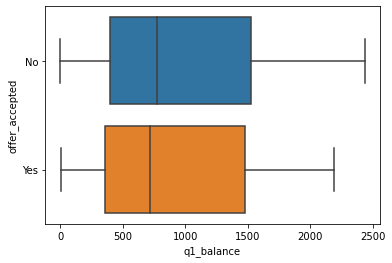

1st Quartile:  392.0  3rd Quartile:  1520.75


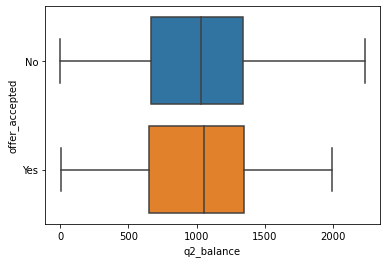

1st Quartile:  663.0  3rd Quartile:  1342.0


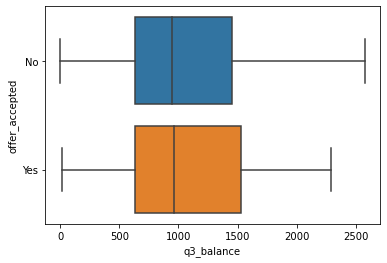

1st Quartile:  633.0  3rd Quartile:  1462.0


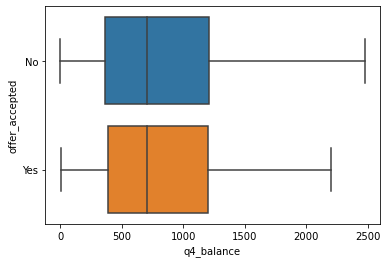

1st Quartile:  363.0  3rd Quartile:  1211.0


In [264]:
for col in df_numeric: # Visualizing Outliers
    sns.boxplot(x = df_encoded[col],y = "offer_accepted", data = df_encoded)
    
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    #Calculating Quartiles of that column
    
    plt.show()
    print("1st Quartile: ", Q1, " 3rd Quartile: ", Q3)

# Modeling our predictor :

First of all we'll define the predicting features (X) and the target to be predicted (y)

In [265]:
X = df_encoded.drop("offer_accepted",axis = 1)
y = df_encoded["offer_accepted"]

Designing a function for the model evaluation :

In [266]:
def Score_Analisis(classification, X_test, y_test): #Function that tests the prediction of Logistic models with a variety of parameters
    predictions = classification.predict(X_test) 
    print("Accuracy score: %4.2f " % accuracy_score(y_test, predictions))
    print("Precision score : %4.2f" % (precision_score(y_test,predictions,pos_label='Yes')))
    print("Recall score : %4.2f" % (recall_score(y_test,predictions,pos_label='Yes')))
    print("F1-score : %4.2f" % (f1_score(y_test,predictions,pos_label='Yes')))
    #print("Kappa score : %4.2f" % (cohen_kappa_score(y_test, predictions)))
    #print(classification_report(y_test, predictions, labels=['No', 'Yes'], zero_division = 1))
    plot_confusion_matrix(classification, X_test, y_test) 
    plt.show()

**Precision** quantifies the number of positive class predictions that actually belong to the positive class. TruePositive / (TruePositive + FakePositive)

**Recall quantifies** the number of positive class predictions made out of all positive examples in the dataset. 
TruePositive / (TruePositive + FakeNegative) 

#### Now we'll split the data into traning set for training the model (fitting) and test set to test the predictions.

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Since Linear models and KNearestNeighbors use euclidean as their distance metric we should scale our features in order to give them the same importance.

In [268]:
scaler = StandardScaler() # initialize the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LogisticRegression Model (unbalanced data)

In [269]:
log = LogisticRegression().fit(X_train_scaled, y_train)

Accuracy score: 0.95 
Precision score : 0.00
Recall score : 0.00
F1-score : 0.00


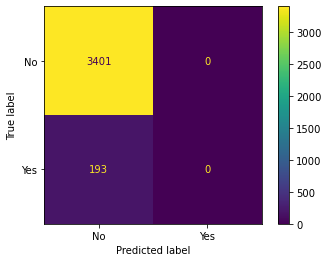

In [270]:
Score_Analisis(log, X_test_scaled, y_test)

#### Clear example of very bad performance with unbalanced data so we have to deal with it

# Fixing the target imbalance through undersampling (Applying on the train and test set)

#### TomekLinks under-sampling method will clean the database by removing ambiguous samples close to the decision boundary, In other words it will remove some borderline and noisy instances from the majority class.

In [271]:
tl = TomekLinks()
#Fitting tomelinks onto the dataset
X_tl, y_tl = tl.fit_resample(X, y)

In [272]:
y.value_counts()

No     16945
Yes     1021
Name: offer_accepted, dtype: int64

In [273]:
y_tl.value_counts()

No     16413
Yes     1021
Name: offer_accepted, dtype: int64

Because the procedure only removes so-named "Tomek Links", we would not expect the resulting transformed dataset to be balanced, only less ambiguous along the class boundary.

This highlights that although finding the ambiguous examples on the class boundary is useful, alone, it is not a great undersampling technique. In practice, the Tomek Links procedure is often **combined** with other methods.

### Now let's apply Random undersampling method to the data we've got after using TomekLink. 
#### This technique will Under-sample the majority class by randomly picking samples until we reach our desired balance.

In [274]:
r_undersample = RandomUnderSampler()

In [275]:
X_ran, y_ran = r_undersample.fit_resample(X_tl, y_tl)

In [276]:
y_ran.value_counts()

Yes    1021
No     1021
Name: offer_accepted, dtype: int64

#### Now that we have our dataset balanced let's test a LogisticRegression model to compare the scores with our previous one.

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X_ran, y_ran, test_size=0.2, random_state=123)

In [278]:
log = LogisticRegression().fit(X_train, y_train)

Accuracy score: 0.70 
Precision score : 0.71
Recall score : 0.70
F1-score : 0.70


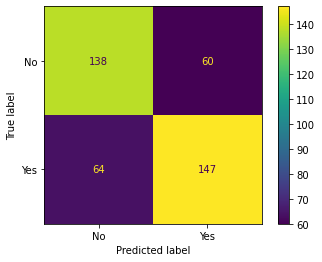

In [279]:
Score_Analisis(log, X_test, y_test)

#### Not bad, the accuracy dropped but this way the model managed to predict most of the positive labels, which makes it better.

# Fixing the target imbalance through Oversampling SMOTE (Applying on the train and test data)

Now we will try the Smote method to oversample the "offer accepted" feature to balance the data.

In [280]:
smote = SMOTE(random_state=123)
X_sm, y_sm = smote.fit_sample(X, y)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=123)

In [282]:
scaler = StandardScaler() # initialize the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LogisticRegression Model

In [283]:
log = LogisticRegression().fit(X_train_scaled, y_train)

Accuracy score: 0.82 
Precision score : 0.81
Recall score : 0.85
F1-score : 0.83


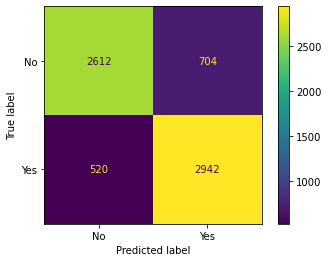

In [284]:
Score_Analisis(log, X_test_scaled, y_test)

#### Turned out that oversampling gives better results than undersampling as for this approach so let's try now with a different model that could give us more insights with oversampled data.

### RandomForestClassifier

In [285]:
rfc = RandomForestClassifier().fit(X_train, y_train)

Accuracy score: 0.96 
Precision score : 0.99
Recall score : 0.94
F1-score : 0.96


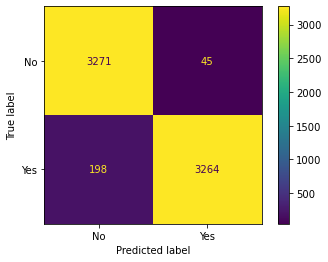

In [286]:
Score_Analisis(rfc, X_test, y_test)

#### This results look a bit unrealistic, that's due to the fact that the test set has the same proportion of Negative and Positive values, note that it would be impossible to balance new data if we did not know the Target "y" value beforehand . 

# Fixing the target imbalance through undersampling (Applying only on the train set)

#### TomekLinks under-sampling method will clean the database by removing ambiguous samples close to the decision boundary, In other words it will remove some borderline and noisy instances from the majority class.

Now that we are applying the undersampling after the train test split make sure you asign the  "stratify" parameter to the target (y), this way we get the same percentage of yes in the train and in the test set, without this parameter it would split the data randomly.

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y, random_state=123)

#### Quick check of the proportion in order to confirm that our stratify worked.

In [288]:
# proportion in the train y
y_train[y_train=="Yes"].count()/y_train.count()

0.056846646256610074

In [289]:
# proportion in the test y
y_test[y_test=="Yes"].count()/y_test.count()

0.05676126878130217

In [290]:
scaler = StandardScaler() # initialize the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [291]:
y_train.value_counts()

No     13555
Yes      817
Name: offer_accepted, dtype: int64

In [292]:
tl = TomekLinks()
#Fitting tomelinks onto the dataset
X_train_tl, y_train_tl = tl.fit_resample(X_train_scaled, y_train)

Because the procedure only removes so-named "Tomek Links", we would not expect the resulting transformed dataset to be balanced, only less ambiguous along the class boundary.

This highlights that although finding the ambiguous examples on the class boundary is useful,but alone, it is not a great undersampling technique. In practice, the Tomek Links procedure is often **combined** with other methods.

### Now let's apply Random undersampling method to the data we've got after using TomekLink. 
#### This technique will Under-sample the majority class by randomly picking samples until we reach our desired balance.

In [293]:
r_undersample = RandomUnderSampler()

In [294]:
X_train_ran, y_train_ran = r_undersample.fit_resample(X_train_tl, y_train_tl)

In [295]:
y_train_ran.value_counts()

Yes    817
No     817
Name: offer_accepted, dtype: int64

#### Now that we have our trainset balanced let's test a LogisticRegression model to compare the scores with our previous one.

In [296]:
log = LogisticRegression().fit(X_train_ran, y_train_ran)

Accuracy score: 0.67 
Precision score : 0.11
Recall score : 0.72
F1-score : 0.20


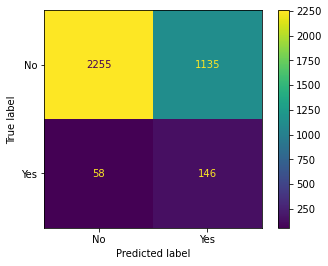

In [297]:
Score_Analisis(log, X_test_scaled, y_test)

# Fixing the target imbalance through Oversampling SMOTE (Applying only on the train data)


Now that we are applying the oversampling after the train test split, so make sure you asign the "stratify" parameter to the target (y), this way we get the same percentage of yes in the train and in the test set.

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y, random_state=123)

In [299]:
scaler = StandardScaler() # initialize the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [300]:
y_train.value_counts()

No     13555
Yes      817
Name: offer_accepted, dtype: int64

In [301]:
smote = SMOTE(random_state=123)
X_train_sm, y_train_sm = smote.fit_sample(X_train_scaled, y_train)

In [302]:
log = LogisticRegression().fit(X_train_sm, y_train_sm)

Accuracy score: 0.70 
Precision score : 0.12
Recall score : 0.68
F1-score : 0.20


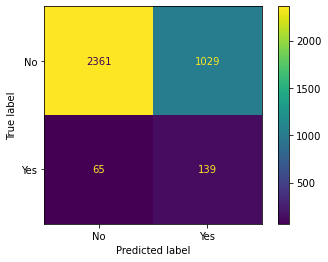

In [303]:
Score_Analisis(log, X_test_scaled, y_test)

#### Turns out that oversampling gives similar results than undersampling, it gets more True Negatives, but has less True positives than with the undersampling method. 


### RandomForestClassifier (note that this model doesn't need scaling)

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y, random_state=123)

In [305]:
smote = SMOTE(random_state=123)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

In [306]:
rfc2 = RandomForestClassifier().fit(X_train_sm, y_train_sm)

Accuracy score: 0.93 
Precision score : 0.18
Recall score : 0.05
F1-score : 0.08


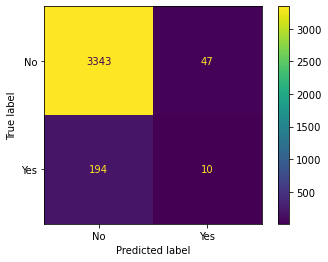

In [307]:
Score_Analisis(rfc2, X_test, y_test)

Pretty bad positive predictions
#### Let's check the score of this model on the train set and compare the results.

Accuracy score: 1.00 
Precision score : 1.00
Recall score : 1.00
F1-score : 1.00


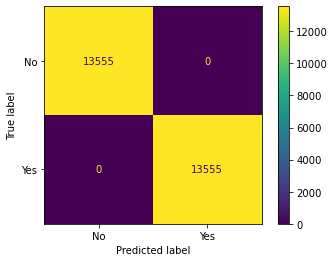

In [308]:
Score_Analisis(rfc2, X_train_sm, y_train_sm)

#### A perfect example of overfitting ,  the model managed to get all the complexity of the trainset, but failed to predict new data ( test set)

# Balancing the whole dataset VS Balancing only the train set :

Remember that the purpose of the test set is to evaluate our model, in a way that the scores of our predictions give us a hint of how our model would perform predicting new data. So if we apply our balancing on the test set, the testing performance wouldn't be on new, unseen data.

Imagine that after building and evaluating the model the company asks us to predict new data (most likely it will be unbalanced aswell) , from this new data we do not know wether if the card_offer is accepted or not, it will be our model's job to identify them and we will not know if we got a correct or incorrect prediction. 

Taking this into consideration, does it make sense to balance the test set? clearly not.

Also, note that we will not be able to balance new data if we do not know the real proportion of True positives and True negatives. So it doesn't really make much sense to evaluate our model balancing the y_test.



# Extra Questions:
### 1. What are the demographics and charecteristics of customers who accept or reject credit offers?

#### Categorical demographics and characteristics comparison:

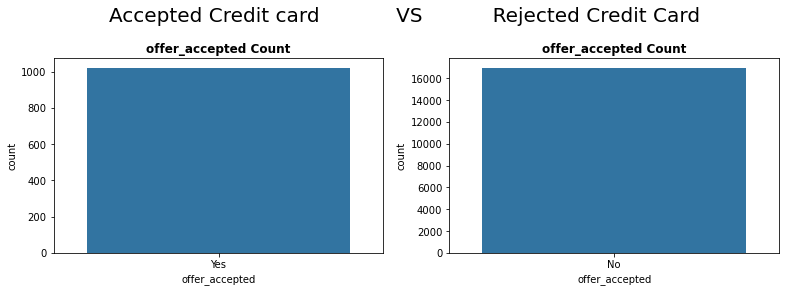

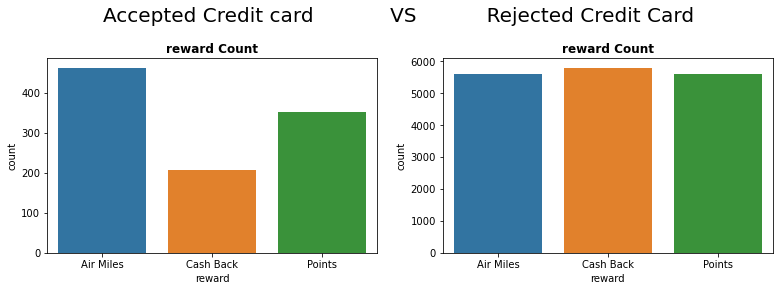

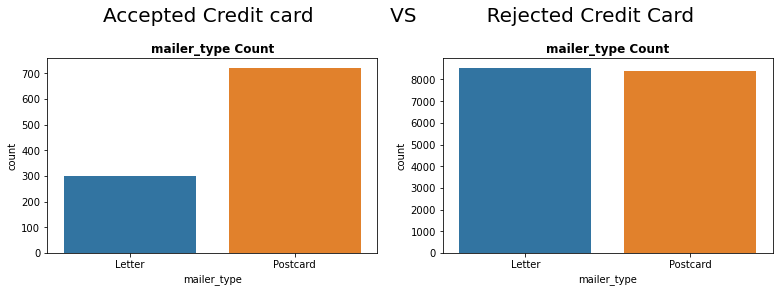

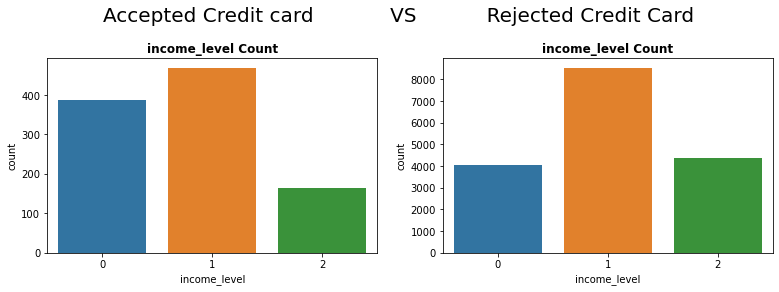

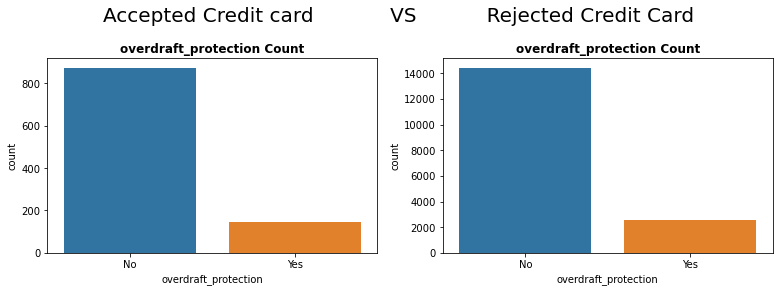

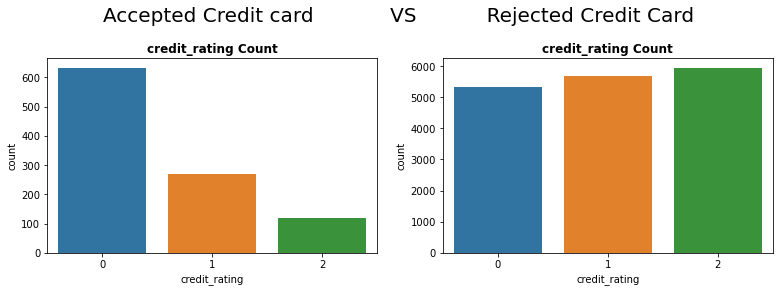

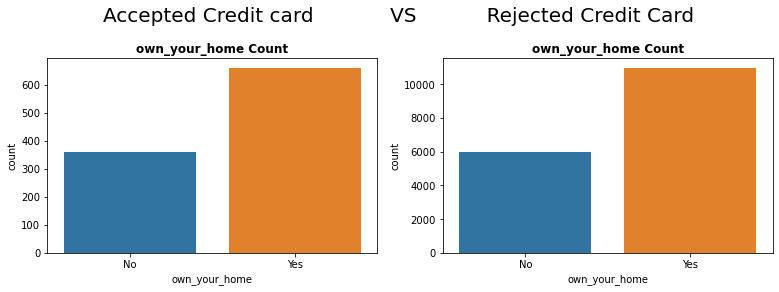

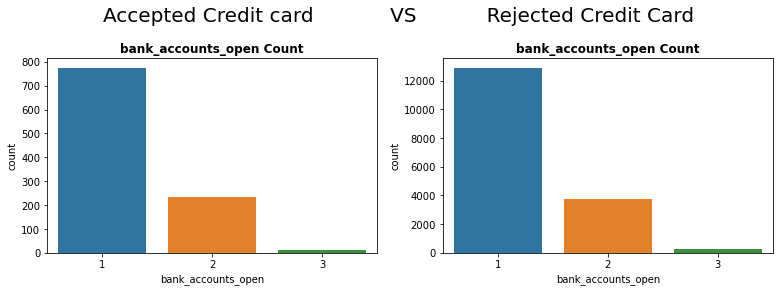

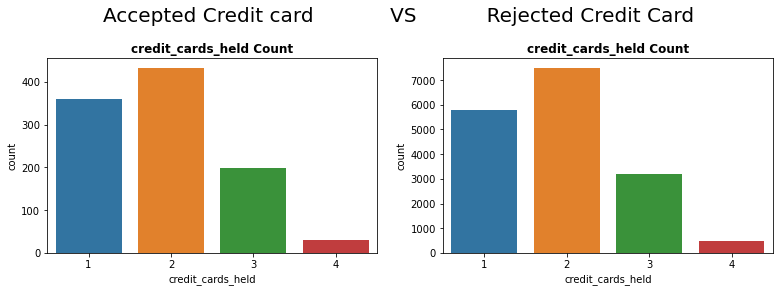

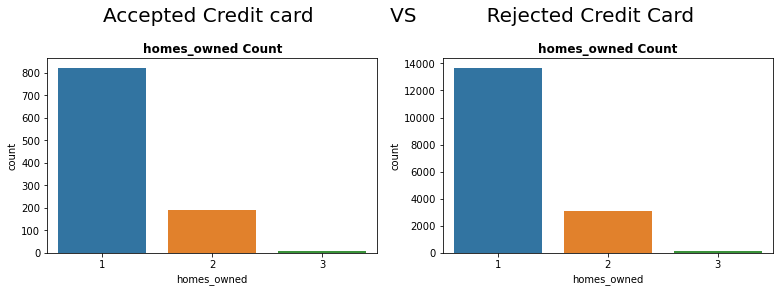

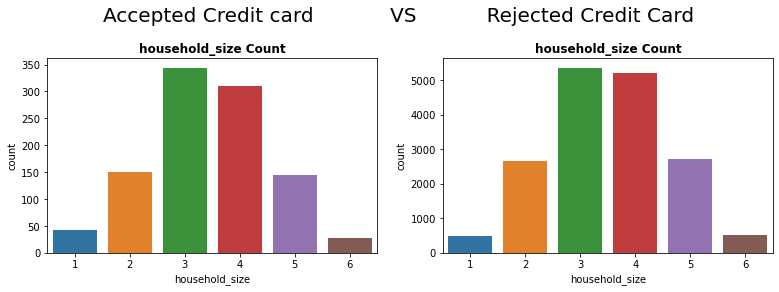

In [183]:
for col in df_categorical :
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle('Accepted Credit card            VS           Rejected Credit Card', fontsize = 20)
    fig.subplots_adjust(top=0.8)
    ax[0].set_title(col+" Count", fontweight = 'bold')
    ax[1].set_title(col+" Count", fontweight = 'bold')
    sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="Yes"], ax = ax[0])
    sns.countplot(x = col, data = df_categorical[df_categorical["offer_accepted"]=="No"],ax = ax[1])
    plt.show()

#### From this plots we can gather some insights about the demographics and charecteristics of customers who accept or reject credit card offers.

According to the previous visualizations :
- People who accept the credit card offer prefer the **airmiles** and **points** rewards (in that order), which differs from the people who reject the card who do not really care about the reward.
- People who accept the credit card have a slightly lower **income level** than the ones who reject the offer
- People who accept the credit card have a lower **credit rating** than the ones who reject the offer.
- They receive the offer mostly through **postmail** instead of **letter**, which differs from the people who reject the card.




#### Plotting feature importances from RandomForest model to confirm our previous insights gathered from the visualizations: 

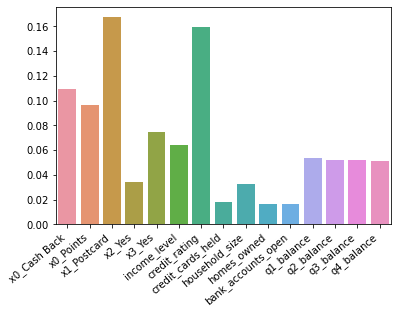

<Figure size 576x288 with 0 Axes>

In [188]:
#Barplot to show how much each feature affects the model's prediction
ax = sns.barplot(x = X.columns, y = rfc2.feature_importances_) 
plt.figure(figsize=(8,4)) 

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #Rotating labels  for readibility
plt.tight_layout()
plt.show()

### 2. What insights did you discover within your analysis which would be meaninful to the bank?

To improve their credit card offer acceptance ratio I would encourage the bank to focus on:
- Gather or add more information from the customers to get more insights.
- Clients with lower **credit rating** and **income level**.
- Deliver the offer by the **postal service** since it tends to have more positive outcomes.
- Offer the **airmiles** and **points** and improve the **cash_back** reward offer.


# THE END 

### TO DO NEXT:

- Get more insights about the different credit_rating, postal_services and rewards to get more detailed information on what should the bank focus using groupby. 
- Get the correlation between categorical values using Pearson's chi-squared test to see if by dropping some columns it gives better results.